In [2]:
import numpy             as np
import pandas            as pd 
import geopandas         as gpd
import seaborn           as sns
import matplotlib.pyplot as plt
from shapely import geometry

In [3]:
path_shape_data_final = "../geo_data/final/clima_australia.shp"

In [12]:
gdf = gpd.read_file(path_shape_data_final).set_index('id')

In [13]:
geometry = gdf.pop('geometry')

### Escalado

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_array = scaler.fit_transform(gdf)
scaled_df = pd.DataFrame(scaled_array,columns=gdf.columns,index=gdf.index)

### Estudio de Correlación

<AxesSubplot:>

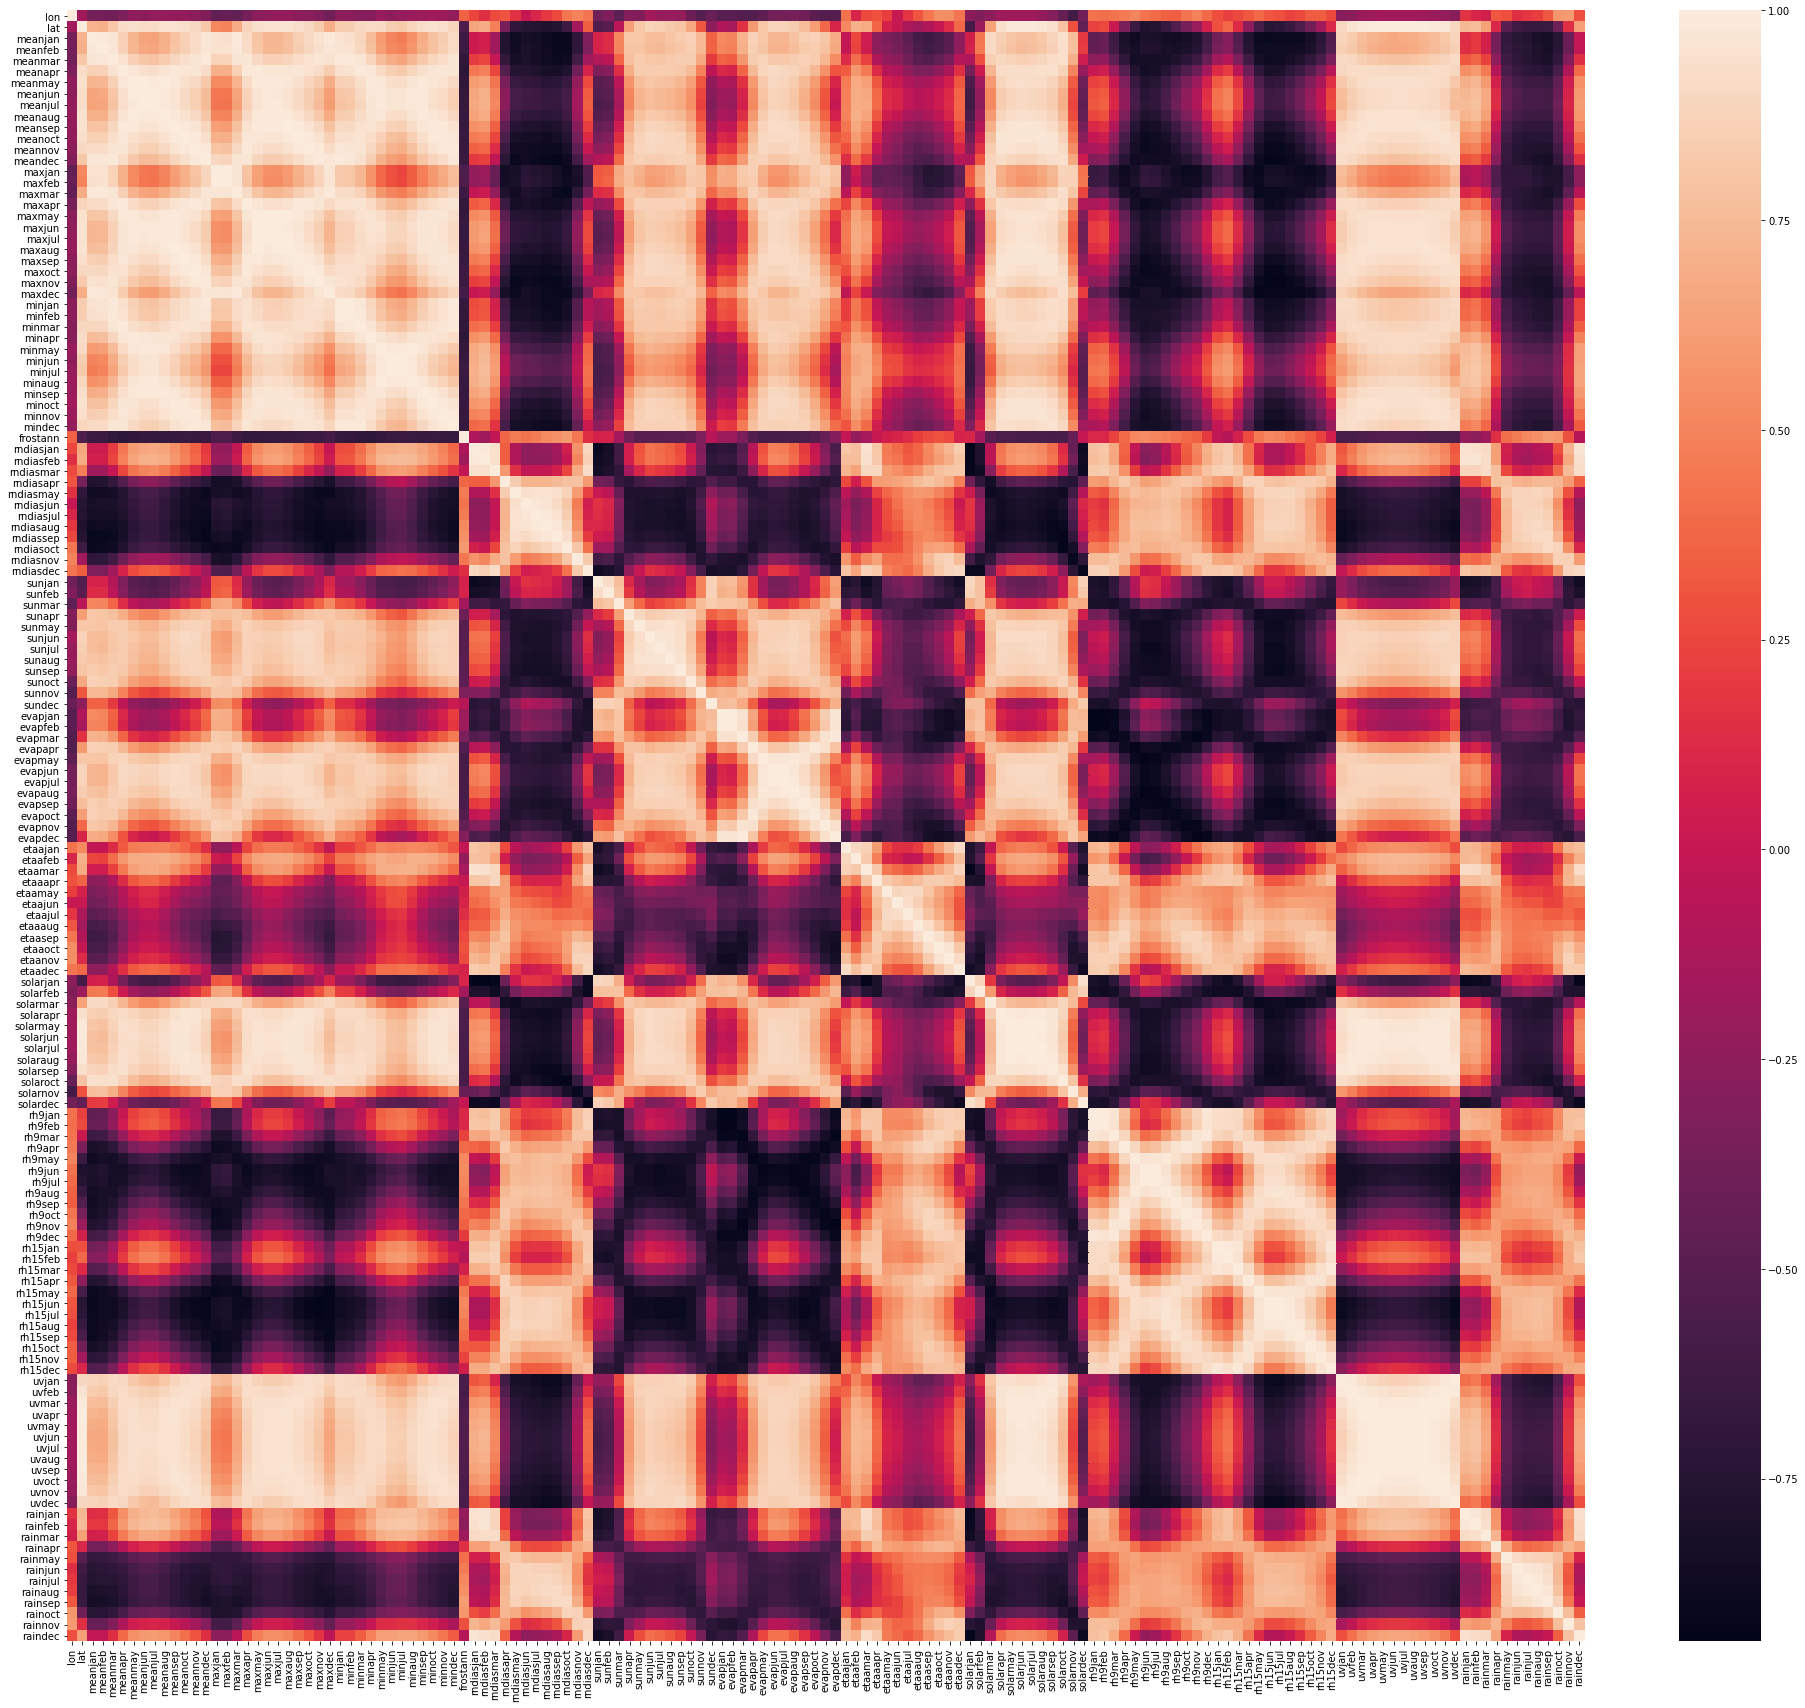

In [19]:
fig,ax = plt.subplots(figsize=(34,30))
sns.heatmap(scaled_df.corr(),ax=ax)

#### Como podemos ver, hay una clara relación entre las variables, lo cual es de esperar ya que tenemos 12 variables de temperatura, de lluvia, y de todas las demás características climáticas, y esas 12 variables entre ellasse encuentran fuertemente correladas.

### Debemos realizar una reducción de dimensionalidad con PCA

In [20]:
from sklearn.decomposition import PCA

pca_object = PCA()
pca_object.fit(scaled_df)

transformed_array = pca_object.transform(scaled_df)

df_transformed = pd.DataFrame(data=transformed_array,index=scaled_df.index,columns=['PC{}'.format(i) for i in range(1,pca_object.n_components_+1)])

<AxesSubplot:>

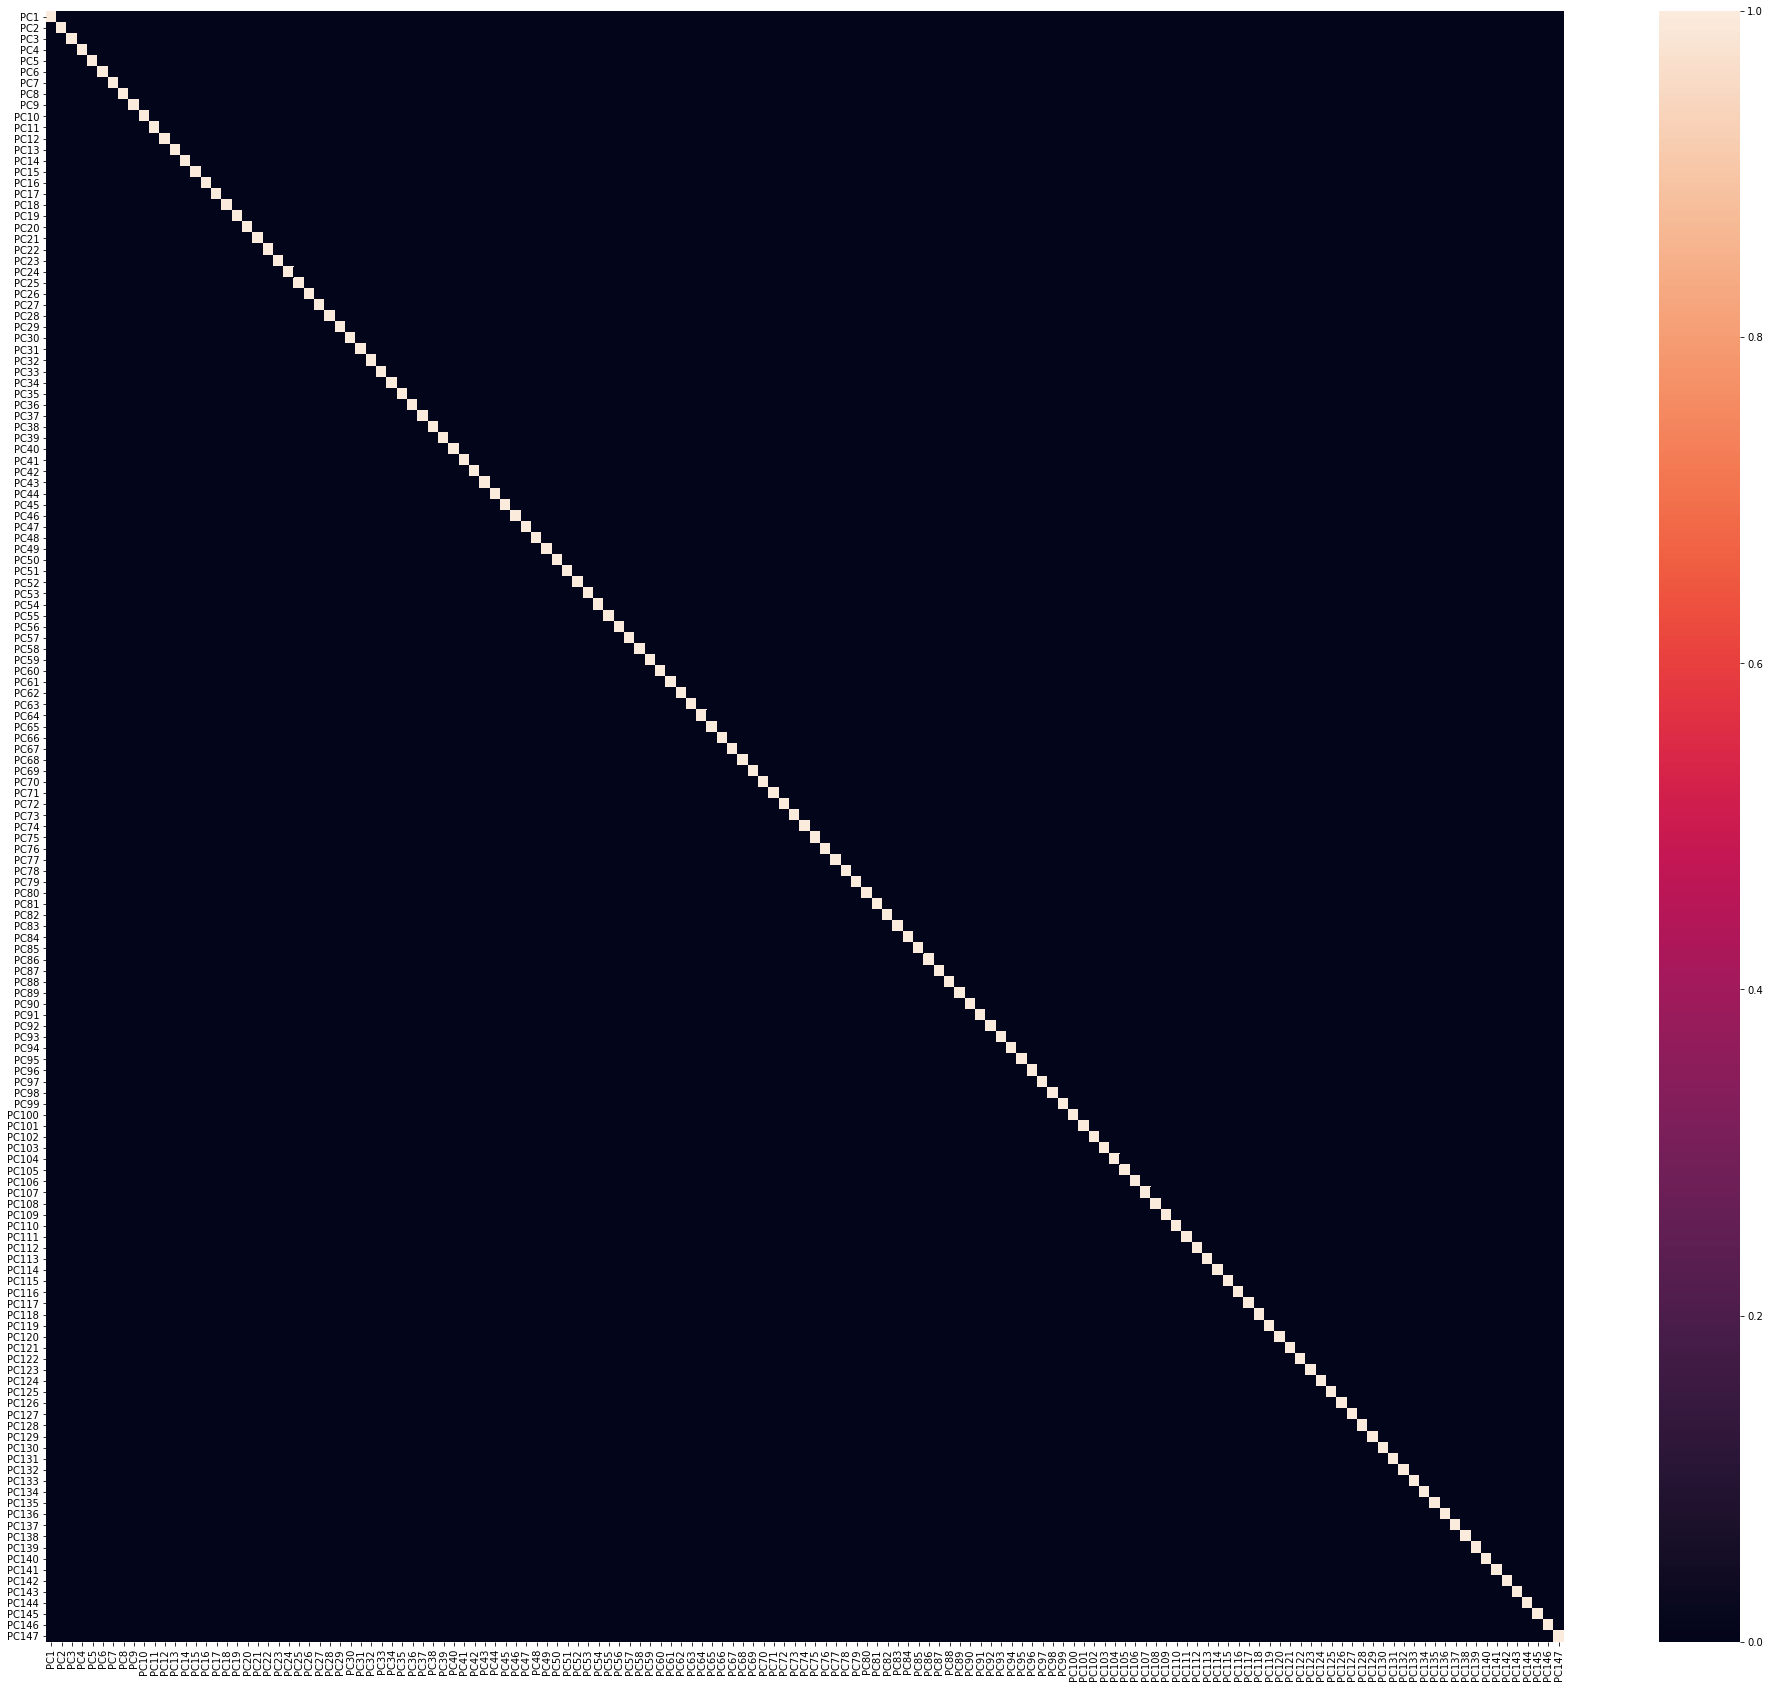

In [22]:
fig,ax = plt.subplots(figsize=(34,30))
sns.heatmap(df_transformed.corr(),ax=ax)

#### Gracias al PCA las nuevas componentes principales se encuentran incorreladas. Vamos a averiguar cuántas componentes son necesarias para el clustering, sin sacrificar mucha varianza explicada:

(0.0, 10.0)

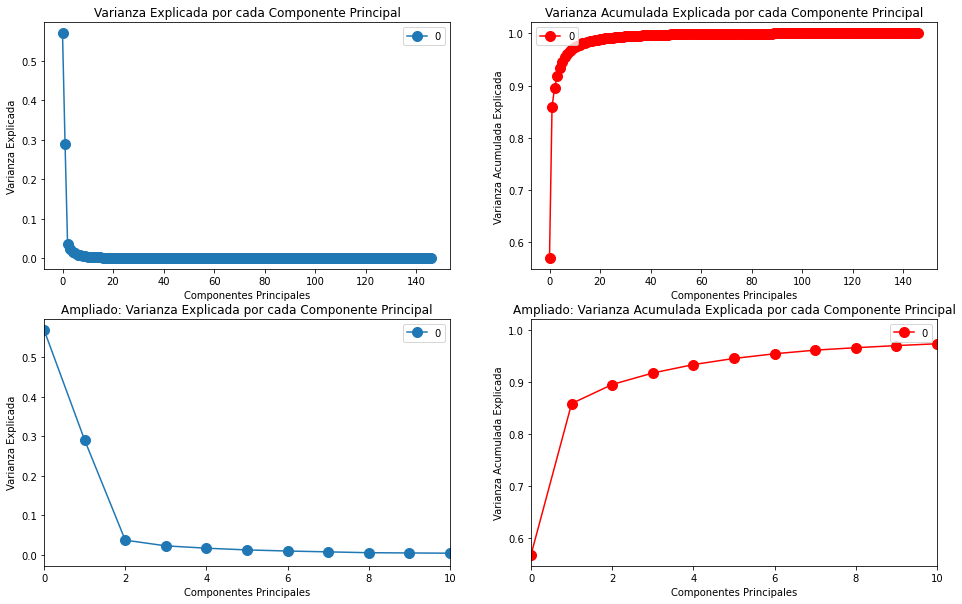

In [33]:
var_explicada  = pca_object.explained_variance_ratio_
suma_acumulada = np.cumsum(pca_object.explained_variance_ratio_)

fig,axes = plt.subplots(figsize=(16,10),ncols=2,nrows=2)

pd.DataFrame(var_explicada).plot(ax=axes[0,0],marker='o',markersize=10)
pd.DataFrame(suma_acumulada).plot(ax=axes[0,1],marker='o',markersize=10,color='red')
pd.DataFrame(var_explicada).plot(ax=axes[1,0],marker='o',markersize=10)
pd.DataFrame(suma_acumulada).plot(ax=axes[1,1],marker='o',markersize=10,color='red')

axes[0,0].set_title("Varianza Explicada por cada Componente Principal")
axes[0,0].set_xlabel("Componentes Principales")
axes[0,0].set_ylabel("Varianza Explicada")

axes[0,1].set_title("Varianza Acumulada Explicada por cada Componente Principal")
axes[0,1].set_xlabel("Componentes Principales")
axes[0,1].set_ylabel("Varianza Acumulada Explicada")

axes[1,0].set_title("Ampliado: Varianza Explicada por cada Componente Principal")
axes[1,0].set_xlabel("Componentes Principales")
axes[1,0].set_ylabel("Varianza Explicada")

axes[1,1].set_title("Ampliado: Varianza Acumulada Explicada por cada Componente Principal")
axes[1,1].set_xlabel("Componentes Principales")
axes[1,1].set_ylabel("Varianza Acumulada Explicada")

axes[1,0].set_xlim([0, 10])
axes[1,1].set_xlim([0, 10])

#### Con las gráficas anteriores, podemos ver que con las tres primeras componentes principales ya somos capaces de tener una varianza explicada de alrededor del 90%, y con 4 explicamos un 93%. Esto es un gran avance, hemos pasado de tener más de 140 variables a tener solo 4.

### Vamos a ver qué variables influyen más en explicar esta varianza explicada por las primeras 10 componentes:

In [39]:
df_pca = pd.DataFrame(data=pca_object.components_,columns=scaled_df.columns,index=['PC{}'.format(i) for i in range(1,pca_object.n_components_+1)])
df_pca = df_pca.head(10).transpose()
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
lon,0.038254,0.049086,0.158421,-0.318790,0.018037,0.168296,0.182430,0.254263,-0.172152,0.218472
lat,-0.094498,0.072564,-0.016270,-0.032619,0.042799,-0.018866,-0.032989,-0.093280,0.004828,0.048970
meanjan,-0.103178,-0.034409,-0.047617,-0.027556,0.076676,0.066263,0.050216,0.057223,-0.002600,-0.024841
meanfeb,-0.101966,-0.032786,-0.069094,-0.023880,0.073944,0.109905,0.046409,0.098488,0.005271,-0.034495
meanmar,-0.105601,-0.003719,-0.071299,0.022767,0.048924,0.091006,0.040850,0.062490,-0.021423,-0.058753


<AxesSubplot:>

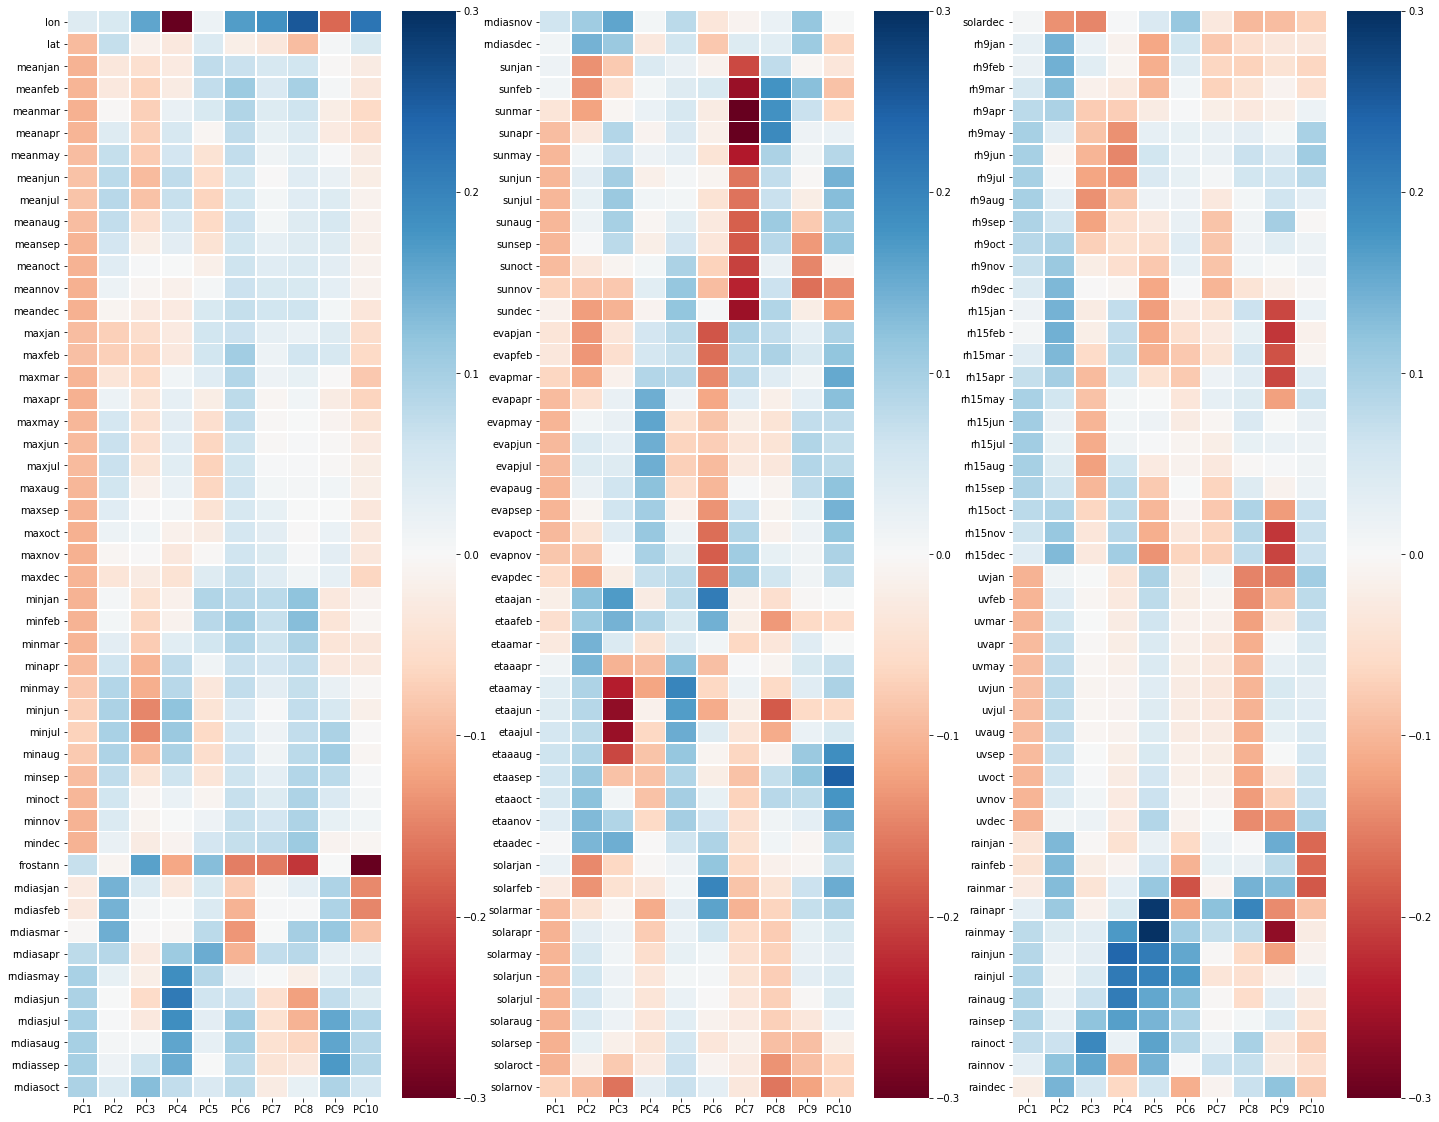

In [49]:
fig,axes = plt.subplots(figsize=(24,20),ncols=3,nrows=1)
sns.heatmap(df_pca.head(49)         ,cmap='RdBu',ax=axes[0],linewidths=.8,vmax=.3,vmin=-.3)
sns.heatmap(df_pca.head(98).tail(49),cmap='RdBu',ax=axes[1],linewidths=.8,vmax=.3,vmin=-.3)
sns.heatmap(df_pca.tail(49)         ,cmap='RdBu',ax=axes[2],linewidths=.8,vmax=.3,vmin=-.3)

#### Finalmente, vamos a visualizar los datos utilizando las primeras 4 componentes principales:

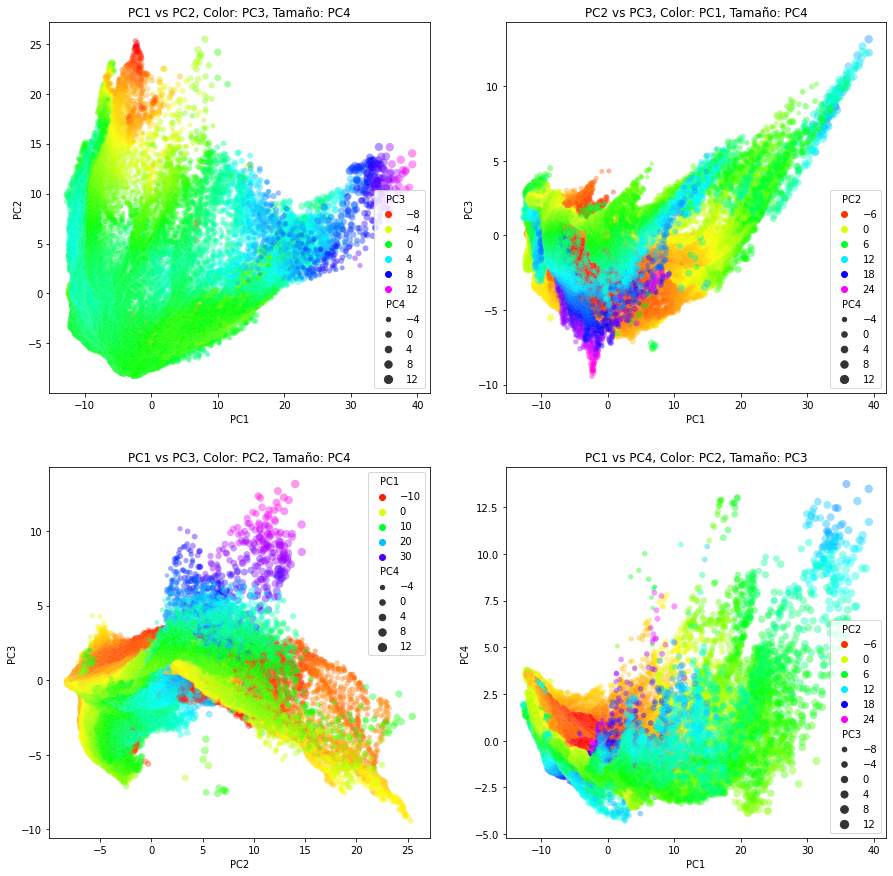

In [63]:
fig,axes = plt.subplots(figsize=(15,15),ncols=2,nrows=2)

sns.scatterplot(data=df_transformed,x='PC1',y='PC2',hue='PC3',size='PC4',palette='gist_rainbow',ax=axes[0,0],alpha=.4,linewidth=.1)
sns.scatterplot(data=df_transformed,x='PC1',y='PC3',hue='PC2',size='PC4',palette='gist_rainbow',ax=axes[0,1],alpha=.4,linewidth=.1)
sns.scatterplot(data=df_transformed,x='PC2',y='PC3',hue='PC1',size='PC4',palette='gist_rainbow',ax=axes[1,0],alpha=.4,linewidth=.1)
sns.scatterplot(data=df_transformed,x='PC1',y='PC4',hue='PC2',size='PC3',palette='gist_rainbow',ax=axes[1,1],alpha=.4,linewidth=.1)

axes[0,0].set_title('PC1 vs PC2, Color: PC3, Tamaño: PC4')
axes[1,0].set_title('PC1 vs PC3, Color: PC2, Tamaño: PC4')
axes[0,1].set_title('PC2 vs PC3, Color: PC1, Tamaño: PC4')
axes[1,1].set_title('PC1 vs PC4, Color: PC2, Tamaño: PC3')

plt.show()

#### Estas gráficas ofrecen poca información, pero muestran ciertas relaciones, en la mayoría de casos no-lineales, entre los datos pintados.

### Procedemos a realizar el Clustering:
#### A la hora de elegir el nº de clusters, para este caso específico, ya que estamos buscando clasificar los distintos climas en los que se divide el continente australiano, he decidido separar en 6 clusters la salida. Esta decisión se basa en que muchos modelos climáticos distinguen 6 grandes climas claramente identificables presentes en Australia. De esta manera, podemos contrastar la salida del modelo con datos geográficos realizados por climatólogos expertos. 
#### A pesar de decidir el nº de clusters, es imprescindible que comprobemos la viabilidad de crear estos 6 clusters. Para ello, utilizarems el Silhouette Score, computado con la función 'silhouette_score' de ScikitLearn metrics.

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn.pipeline      import Pipeline
from sklearn.metrics       import silhouette_score

In [94]:
df_clstr = df_transformed[['PC1','PC2','PC3','PC4']]

In [104]:
sil_scores = pd.DataFrame(columns=['ncluster','silhouette'])

X = df_clstr
range_n_clusters = list(range(2, 15))
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          ", El silhouette_score es de:", silhouette_avg)
    sil_scores = sil_scores.append({'ncluster':n_clusters,'silhouette':silhouette_avg},ignore_index=True)

Para n_clusters = 2 , El silhouette_score es de: 0.408291719112517
Para n_clusters = 3 , El silhouette_score es de: 0.42185291568245364
Para n_clusters = 4 , El silhouette_score es de: 0.39884575149770785
Para n_clusters = 5 , El silhouette_score es de: 0.37489329950217454
Para n_clusters = 6 , El silhouette_score es de: 0.39286894574499853
Para n_clusters = 7 , El silhouette_score es de: 0.38447005428948783
Para n_clusters = 8 , El silhouette_score es de: 0.3669006582402365
Para n_clusters = 9 , El silhouette_score es de: 0.3513820141176826
Para n_clusters = 10 , El silhouette_score es de: 0.34868864233017344
Para n_clusters = 11 , El silhouette_score es de: 0.3289363664435744
Para n_clusters = 12 , El silhouette_score es de: 0.32625956952644436
Para n_clusters = 13 , El silhouette_score es de: 0.33206555572165036
Para n_clusters = 14 , El silhouette_score es de: 0.3375622591125511


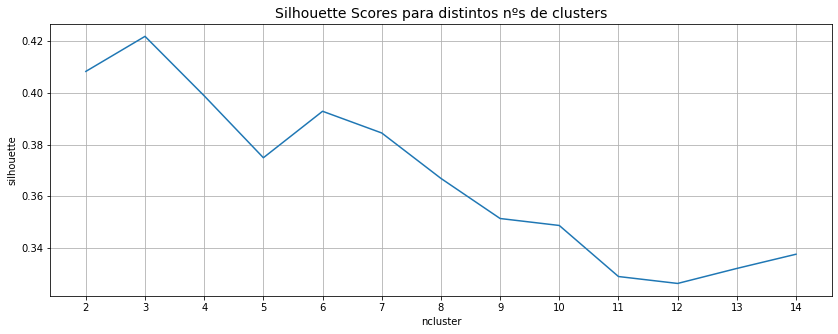

In [119]:
fig, ax = plt.subplots(figsize=(14,5))
sns.lineplot(x=sil_scores.ncluster, y=sil_scores.silhouette, ax=ax)

ax.set_title('Silhouette Scores para distintos nºs de clusters')
ax.grid()
ax.set_xticks(range_n_clusters)

plt.show()

### Clustering Pipeline
#### Una vez hemos realizado el estudio de la configuración que buscamos para nuestro modelo, procedemos a entrenar el algoritmo de KMeans.
#### Para el clustering, y para simplificar el uso del modelo en el futuro, voy a utilizar un Pipeline de ScikitLearn, que integra y entrena a la vez el StandardScaler, PCA y el modelo KMeans.

In [180]:
clustering_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',    PCA(n_components  = 4, random_state=1)),
    ('kmeans', KMeans(n_clusters = 6, random_state=1))
])

Como utiliza su propio Standard Scaler y PCA, le proporcionamos los datos iniciales sin ninguna transformación:

In [124]:
clusters = clustering_pipeline.fit_predict(gdf)

Una vez entrenado, hacemos una pequeña visualización con Seaborn usando las coordenadas:

In [128]:
resultados = gdf.copy()
resultados['cluster'] = clusters
resultados.head(3)

,lon,lat,meanjan,meanfeb,meanmar,meanapr,meanmay,meanjun,meanjul,meanaug,...,rainapr,rainmay,rainjun,rainjul,rainaug,rainsep,rainoct,rainnov,raindec,cluster
id,,,,,,,,,,,,,,,,,,,,,
0,113.0625,-25.6875,26.245,27.6,26.24,23.07,19.7,17.21,15.865,16.5,...,15.42,37.66,59.27,46.41,28.42,11.18,5.99,4.01,6.18,2
1,113.0625,-25.5625,26.335,27.6,26.24,23.07,19.7,17.21,15.865,16.5,...,16.15,36.90,58.51,46.56,27.46,11.06,6.33,4.60,8.08,2
2,113.0625,-25.4375,26.385,27.6,26.24,23.07,19.7,17.21,15.865,16.5,...,15.76,35.96,57.87,46.30,26.42,10.41,5.74,3.95,7.84,4


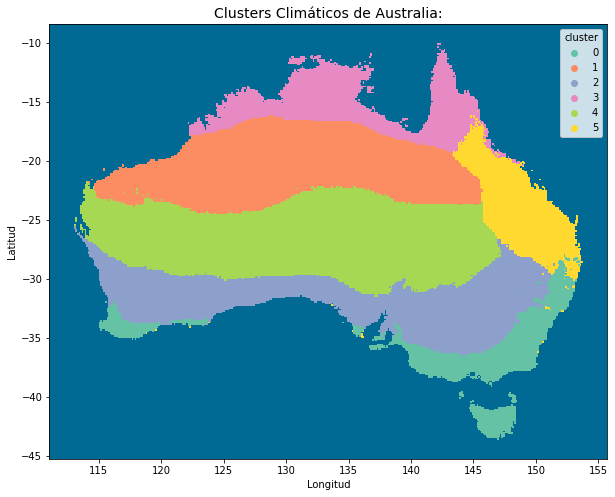

In [176]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=resultados,
                x='lon',
                y='lat',
                linewidth=0,
                hue='cluster',
                alpha=1,
                marker = 's',
                s=3,
                palette='Set2'
               )
ax.set_title('Clusters Climáticos de Australia:')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_facecolor('#006994')

plt.show()

#### Sabemos que la longitud y la latitud pueden influir en las salidas de los clusters, y no son necesariamente datos relacionados con el clima. Por ello, vamos a probar el mismo modelo sin ofrecer información de la localización de cada punto:

In [168]:
datos = list(gdf.columns)
datos.remove('lat')
datos.remove('lon')
gdf_clima = gdf.copy()[datos]

In [182]:
clusters = clustering_pipeline.fit_predict(gdf_clima)

resultados['cluster_sin_geo'] = clusters

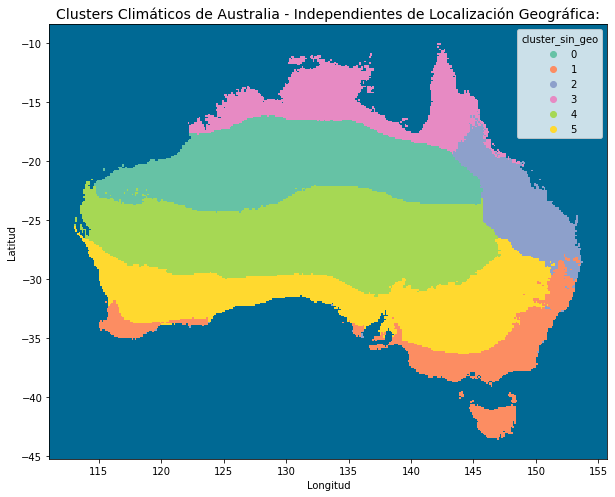

In [183]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=resultados,
                x='lon',
                y='lat',
                linewidth=0,
                hue='cluster_sin_geo',
                alpha=1,
                marker = 's',
                s=3,
                palette='Set2'
               )
ax.set_title('Clusters Climáticos de Australia - Independientes de Localización Geográfica:')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_facecolor('#006994')

plt.show()

### Conclusiones de los clusters encontrados:
#### Una vez tenemos los clusters delimitados, vamos a ver las características que los hacen únicos:

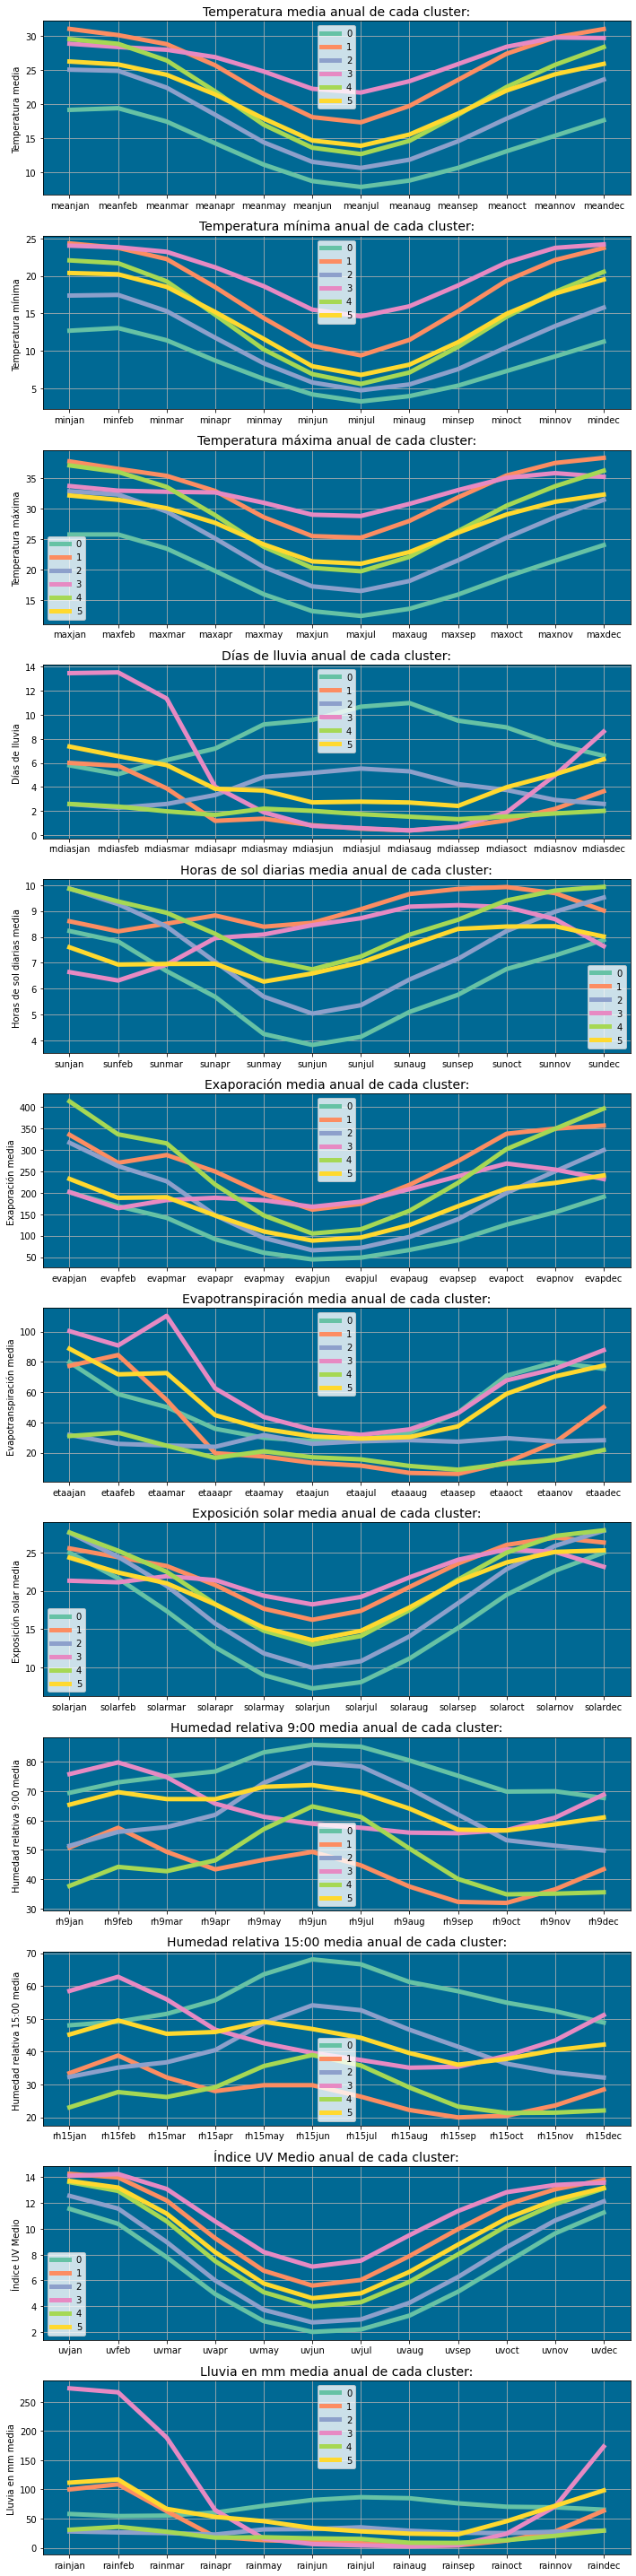

In [245]:
sns.set_palette('Set2')

datos      = ['mean','min','max','rndias','sun','evap','etaa','solar','rh9','rh15','uv','rain']
datos_info = ['Temperatura media ','Temperatura mínima ','Temperatura máxima ','Días de lluvia ',
              'Horas de sol diarias media ','Exaporación media ','Evapotranspiración media ',
              'Exposición solar media ','Humedad relativa 9:00 media ','Humedad relativa 15:00 media ',
              'Índice UV Medio ','Lluvia en mm media ']
fig,axes = plt.subplots(ncols=1,nrows=12,figsize=(10,40))

for i in range(12):
    dato = datos[i]
    desc = datos_info[i]
    info = resultados.groupby('cluster').aggregate({
        dato+'jan':'mean',
        dato+'feb':'mean',
        dato+'mar':'mean',
        dato+'apr':'mean',
        dato+'may':'mean',
        dato+'jun':'mean',
        dato+'jul':'mean',
        dato+'aug':'mean',
        dato+'sep':'mean',
        dato+'oct':'mean',
        dato+'nov':'mean',
        dato+'dec':'mean',
    })

    plotinfo = info.transpose()

    for item in info.transpose().iteritems():
        sns.lineplot(data=item[1], ax=axes[i],label=item[0],linewidth = 5)
    
    axes[i].set_ylabel(desc)
    axes[i].set_title(desc+'anual de cada cluster:')
    axes[i].grid()
    axes[i].set_facecolor('#006994')

fig.tight_layout()
plt.show()